In [33]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string
from datetime import date, time, datetime
import calendar
import warnings
warnings.filterwarnings("ignore")
from cleantext import clean

import emoji
import regex as re
import nltk
from nltk.tokenize import word_tokenize

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer
from deep_translator import GoogleTranslator

nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stopwords = stopwords.words('english')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\65939\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\65939\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\65939\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\65939\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
reviewer_reviews = pd.read_csv('all_reviewer_reviews.csv', index_col=0)
restaurant_reviews = pd.read_csv('../restaurant-data/all_restaurant_reviews.csv', index_col = 0)
print("Shape of data=>",reviewer_reviews.shape)

Shape of data=> (17773, 7)


In [5]:
reviewer_reviews.head(5)

,name,address,review,date,link,reviewer,keep
0,Ya Kun Kaya Toast,"2 Tampines Central 5, Singapore",\nBreakfast \nSet A (S$5.60)\nKaya butter toas...,3h ago,https://www.burpple.com/ya-kun-kaya-toast-66?b...,alamakgirl,1
1,511 Lor Mee,"509 Bedok North Street 3, Singapore",\nLunch\nLor Mee (S$4.50)\nKueh tiao topped wi...,5h ago,https://www.burpple.com/511-lor-mee?bp_ref=%2F...,alamakgirl,1
2,McDonald's,"60 Yishun Avenue 4, Yishun",\nSupper\nQuarter Pounder with Cheese Meal (S$...,19h ago,https://www.burpple.com/mcdonalds-555?bp_ref=%...,alamakgirl,1
3,Tian Yu Tian Fish Head Steamboat,"537 Bedok North Street 3, Singapore",\nZi Char\nCrispy Noodles (S$4.50)\n,1d ago,https://www.burpple.com/tian-yu-tian-fish-head...,alamakgirl,1
4,Kiroi Freshly Baked Cheese Cake,"123 Bukit Merah Lane 1, Singapore",\nCake\nOriginal (S$9)\nSoft and pillowy. Japa...,1d ago,https://www.burpple.com/kiroi-freshly-baked-ch...,alamakgirl,1


In [6]:
restaurant_reviews.head(5)

,url,name,neighbourhood,price,categories,review,user,date,cleaned_price,cleaned_categories
0,https://www.burpple.com/enchanted-cafe?bp_ref=...,Enchanted Cafe (Farrer Park),Farrer Park,~$20/pax,"['Breakfast & Brunch', 'Cafes & Coffee', 'Cake...",\nEnchanting Christmas dessert \nThis Christma...,Zoey Belle Wannabe,5m ago,20.0,"['Breakfast & Brunch', 'Desserts', 'High Tea',..."
1,https://www.burpple.com/enchanted-cafe?bp_ref=...,Enchanted Cafe (Farrer Park),Farrer Park,~$20/pax,"['Breakfast & Brunch', 'Cafes & Coffee', 'Cake...",\nCold brew rose chocolate and mocha \nLovely ...,Blue Cherry,Apr 18 at 10:06pm,20.0,"['Breakfast & Brunch', 'Desserts', 'High Tea',..."
2,https://www.burpple.com/enchanted-cafe?bp_ref=...,Enchanted Cafe (Farrer Park),Farrer Park,~$20/pax,"['Breakfast & Brunch', 'Cafes & Coffee', 'Cake...",\nCold Brew\nYou gotta try their signature col...,serene goh,"Jun 11, 2021",20.0,"['Breakfast & Brunch', 'Desserts', 'High Tea',..."
3,https://www.burpple.com/enchanted-cafe?bp_ref=...,Enchanted Cafe (Farrer Park),Farrer Park,~$20/pax,"['Breakfast & Brunch', 'Cafes & Coffee', 'Cake...",\nAlmond Butter on Toast\nAlmond Butter on Toa...,serene goh,"Jun 11, 2021",20.0,"['Breakfast & Brunch', 'Desserts', 'High Tea',..."
4,https://www.burpple.com/enchanted-cafe?bp_ref=...,Enchanted Cafe (Farrer Park),Farrer Park,~$20/pax,"['Breakfast & Brunch', 'Cafes & Coffee', 'Cake...",\nAçaí Bowl\nAçaí Bowl ($15.90): A blend of pr...,serene goh,"Jun 11, 2021",20.0,"['Breakfast & Brunch', 'Desserts', 'High Tea',..."


In [7]:
# remove restaurants that are not in available in all_restaurant_reviews 
unique_restaurants = restaurant_reviews['url'].unique()
reviews_available = reviewer_reviews[reviewer_reviews['link'].isin(unique_restaurants)]

In [8]:
# change in number of reviews
result = reviewer_reviews[['reviewer','link']].groupby('reviewer').count().reset_index()
result['num_reviews_available'] = list(reviews_available[['reviewer','link']].groupby('reviewer').count()['link'])
result.rename({'link':'num_reviews_before'}, axis = 1)

,reviewer,num_reviews_before,num_reviews_available
0,DanielFoodDiary,122,26
1,Eatravel,1796,627
2,MightyFoodie,1636,465
3,Vanessa_Kou,1028,326
4,alamakgirl,3173,606
5,iSteven,46,16
6,juliuslim,1448,419
7,thefoodcompendium,4484,1764
8,thiampeng,3134,809
9,veronicaphua,906,434


In [9]:
# total number of reviews 
result.sum()

reviewer                 DanielFoodDiaryEatravelMightyFoodieVanessa_Kou...
link                                                                 17773
num_reviews_available                                                 5492
dtype: object

In [10]:
# drop danielfooddiary and isteven due to lack of reviews
reviewers_to_keep = list(result[result['num_reviews_available']>=100]['reviewer'])
final_reviews = reviews_available[reviews_available['reviewer'].isin(reviewers_to_keep)]
final_reviews

,name,address,review,date,link,reviewer,keep
12,Kazoku Japanese Cuisine,"1 Goldhill Plaza, Singapore ...",\n1-for-1 Don\nKazoku Chirashi Don (S$29.90++)...,4d ago,https://www.burpple.com/kazoku-japanese-cuisin...,alamakgirl,1
31,Tigerlily Patisserie,"350 Joo Chiat Road, Singapore ...","\nBrunch\nBeehive (S$15+)\nLemon, thyme and ly...",Feb 26 at 12:44pm,https://www.burpple.com/tigerlily-patisserie?b...,alamakgirl,1
32,Putien (Northpoint City) ...,"930 Yishun Avenue 2, Singapore ...",\nBirthday Treat \n20% discount \nValid during...,Feb 24 at 10:47pm,https://www.burpple.com/putien-8?bp_ref=%2Ff%2...,alamakgirl,1
35,Our Tampines Hub Hawker Centre (...,"1 Tampines Walk, Singapore ...",\nSet C\nSet C (S$2.50)\n‘Cos it’s Friday \nGo...,Feb 24 at 8:33am,https://www.burpple.com/our-tampines-hub?bp_re...,alamakgirl,1
51,Hokkaido Ramen Santouka (Clarke ...,"6 Eu Tong Sen Street, Singapore ...",\nBirthday Treat\n50% off Tokusen Toroniku Ram...,Feb 19 at 12:27pm,https://www.burpple.com/hokkaido-ramen-santouk...,alamakgirl,1
...,...,...,...,...,...,...,...
880,Yun Nans (Jewel Changi Airport) ...,"78 Airport Boulevard, Singapore ...",\nChinese New Year Special: A “Pen Cai” Quite ...,"Jan 23, 2020",https://www.burpple.com/yun-nans?bp_ref=%2Ff%2...,veronicaphua,1
882,Tiong Bahru Bakery Diner (Funan)...,"107 North Bridge Road, Singapore...",\nWholesome Food With No Compromise In Flavour...,"Jan 22, 2020",https://www.burpple.com/tiong-bahru-bakery-5?b...,veronicaphua,1
883,Tiong Bahru Bakery Diner (Funan)...,"107 North Bridge Road, Singapore...",\nWholesome Food With No Compromise In Flavour...,"Jan 22, 2020",https://www.burpple.com/tiong-bahru-bakery-5?b...,veronicaphua,1
899,Spago by Wolfgang Puck,"10 Bayfront Avenue, Singapore ...",\nNEW Pasta Tasting Menu\nIf you want to carb ...,"Jan 4, 2020",https://www.burpple.com/spago-by-wolfgang-puck...,veronicaphua,1


## Clean reviews

In [11]:
#decontraction
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"didn\'t", "did not", phrase)
    phrase = re.sub(r"don\'t", "do not", phrase)
    phrase = re.sub(r"o\'clock", "clock", phrase)
    phrase = re.sub(r"couldn\'t", "could not", phrase)
    phrase = re.sub(r"that\'s", "that is", phrase)       
    phrase = re.sub(r"go-around", "go around", phrase)  
    # general
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    #phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [12]:
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [15]:
def clean_text(df, deemojize=False, clean_punctuation=False, remove_stopwords=False, lemmatize=False, stemming=False):
    text_list = df['review']

    stopwords = nltk.corpus.stopwords.words('english')
    new_stopwords = ['address', 'note', 'tel', 'website', 'open', 'burpple']
    add_stopwords = set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
        "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
        'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
        'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
        'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
        'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
        'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
        'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
        'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
        'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
        's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
        've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
        "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
        "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
        'won', "won't", 'wouldn', "wouldn't"])
    add_stopwords_2 =  ['n','s','m','i','1','2','3','4','5','6','7','8','9','10','one','two',
        'it','in','ve','well','could','would','really','also','even',
        'alway','always','still','never','much','thing','yet',
        'said','asked','did','go','got','do','make','know','think','come','going',
        'put','went','seem','order','ordered','give','eat','make','get']
    
    stopwords.extend(new_stopwords)
    stopwords.extend(add_stopwords)
    stopwords.extend(add_stopwords_2)

    ### FOR SENTIMENT ANALYSIS< UNCOMMENT THIS
    not_stopwords = {'no','nor','not'} 
    stopwords = set([word for word in stopwords if word not in not_stopwords])

    lemmatizer = WordNetLemmatizer()
    ps = PorterStemmer()
    cleaned_text_list = []
    count = 0
    for text in text_list:

        # lower case
        text = text.lower()
    
        if deemojize:
            text = emoji.demojize(text)
    
        if clean_punctuation:
            text = re.sub(r'[^\w\s]', '', text)

        # translate to english
        text = GoogleTranslator(source='auto', target='en').translate(text)
    
        # tokenize
        tokens = word_tokenize(text)

        tokens = [decontracted(word) for word in tokens]

        if remove_stopwords:
            tokens = [word for word in tokens if word not in stopwords]
            tokens = [word for word in tokens if 'http' not in word]
            tokens = [word for word in tokens if 'www' not in word]

        if lemmatize:
            # POS tagging
            tokens = [nltk.pos_tag([word]) for word in tokens]
            # lemmatization
            tokens = [lemmatizer.lemmatize(word[0][0], get_wordnet_pos(word[0][1])) 
                if get_wordnet_pos(word[0][1])!=None else lemmatizer.lemmatize(word[0][0]) for word in tokens]
    
        if stemming:
            tokens = [ps.stem(word) for word in tokens]
    
        # concatenate tokens back
        cleaned_text = " ".join(tokens)
        cleaned_text_list.append(cleaned_text)

        if count%1000 == 0:
            print(count)
        count+=1

    df['cleaned_text'] = cleaned_text_list
    
    return df

In [20]:
final_reviews['review'].head()

12    \n1-for-1 Don\nKazoku Chirashi Don (S$29.90++)...
31    \nBrunch\nBeehive (S$15+)\nLemon, thyme and ly...
32    \nBirthday Treat \n20% discount \nValid during...
35    \nSet C\nSet C (S$2.50)\n‘Cos it’s Friday \nGo...
51    \nBirthday Treat\n50% off Tokusen Toroniku Ram...
Name: review, dtype: object

In [26]:
cleaned_df = clean_text(final_reviews, deemojize=True, clean_punctuation=True, remove_stopwords=True, lemmatize=True, stemming=False)

0
1000
2000
3000
4000
5000


In [28]:
final_reviews['cleaned_text'].head()

12    1for1 kazoku chirashi s2990 thick slice tuna s...
31    brunch beehive s15 lemon thyme lychee honey je...
32    birthday treat 20 discount valid birthday mont...
35    set c set c s250 co friday s250 cashback pay p...
51    birthday treat 50 tokusen toroniku ramen s23 s...
Name: cleaned_text, dtype: object

In [29]:
final_reviews.head(2)

,name,address,review,date,link,reviewer,keep,cleaned_text
12,Kazoku Japanese Cuisine,"1 Goldhill Plaza, Singapore ...",\n1-for-1 Don\nKazoku Chirashi Don (S$29.90++)...,4d ago,https://www.burpple.com/kazoku-japanese-cuisin...,alamakgirl,1,1for1 kazoku chirashi s2990 thick slice tuna s...
31,Tigerlily Patisserie,"350 Joo Chiat Road, Singapore ...","\nBrunch\nBeehive (S$15+)\nLemon, thyme and ly...",Feb 26 at 12:44pm,https://www.burpple.com/tigerlily-patisserie?b...,alamakgirl,1,brunch beehive s15 lemon thyme lychee honey je...


In [30]:
pd.DataFrame(final_reviews).to_csv('./cleaned_reviewer_reviews.csv')

## Num of reviews grouped by restaurant

In [54]:
num_by_reviewer= final_reviews.groupby(['reviewer']).count()
num_by_reviewer

,name,address,review,date,link,keep,cleaned_text
reviewer,,,,,,,
Eatravel,627,627,627,627,627,627,627
MightyFoodie,465,465,465,465,465,465,465
Vanessa_Kou,326,326,326,326,326,326,326
alamakgirl,606,606,606,606,606,606,606
juliuslim,419,419,419,419,419,419,419
thefoodcompendium,1764,1764,1764,1764,1764,1764,1764
thiampeng,809,809,809,809,809,809,809
veronicaphua,434,430,434,434,434,434,434


Text(0.5, 1.0, 'Number of Reviews by Reviewers')

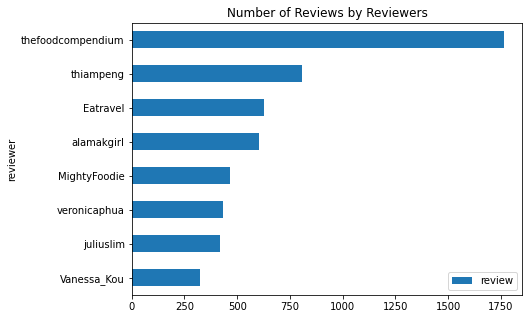

In [77]:
num_by_reviewer_df = pd.DataFrame(num_by_reviewer['review']).sort_values('review')
num_by_reviewer_df.plot(kind='barh',figsize=(7,5))
plt.title('Number of Reviews by Reviewers')

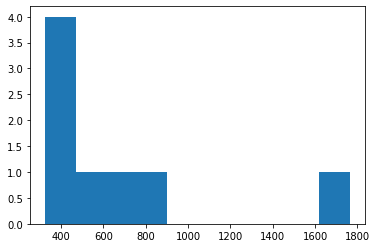

In [78]:
plt.hist(num_by_reviewer.review)
plt.show()

In [155]:
num_by_res= final_reviews.groupby([final_reviews.name]).count()
num_by_res

,address,review,date,link,reviewer,keep,cleaned,cleaned_without_stopwords
name,,,,,,,,
% Arabica (313@Somerset),2,2,2,2,2,2,2,2
% Arabica (Arab Street),2,2,2,2,2,2,2,2
% Arabica (Chip Bee Gardens),6,6,6,6,6,6,6,6
108 Matcha Saro (Suntec City),5,5,5,5,5,5,5,5
136 Hong Kong Street Fish Head Steamboat (Joo Seng),1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...
Shake Shack (Suntec City),1,1,1,1,1,1,1,1
The Coconut Club (Beach Road),1,1,1,1,1,1,1,1
The Frontier (NUS Science Canteen),1,1,1,1,1,1,1,1


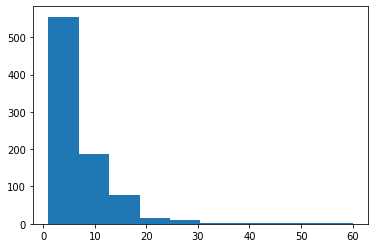

In [172]:
plt.hist(num_by_res.review)
plt.show()

## Word Cloud for reviews for each reviewer and combined

In [ ]:
pip install --no-cache-dir wordcloud

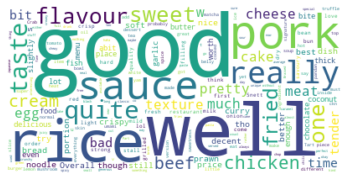

In [79]:
## Word Cloud for final_reviews
#Importing Libraries
import matplotlib.pyplot as plt
%matplotlib inline
import string
from wordcloud import WordCloud, STOPWORDS

# drop address, note, tel, website, Open in reviews
words = []
for r in final_reviews.review:
    if 'Address' not in r and 'Note' not in r and 'Tel' not in r and 'Website' not in r and 'Open' not in r and 'S' not in r:
        words.append(r)

text = " ".join(" ".join(review.split(" ")) for review in words)
# Creating word_cloud with text as argument in .generate() method
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)
# Display the generated Word Cloud
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [80]:
unique_reviewers = final_reviews['reviewer'].unique()

Word cloud for each reviewer with stopwords removed

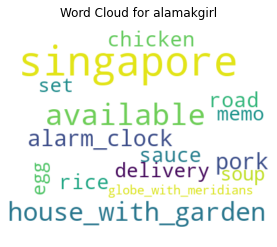

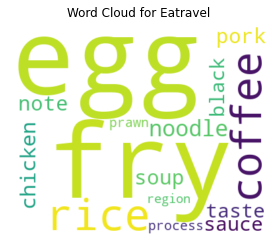

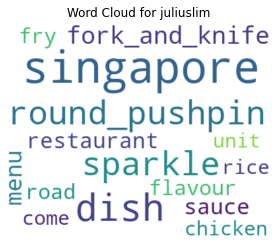

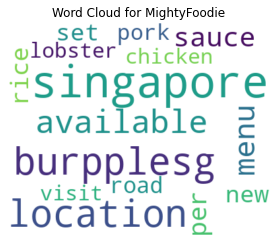

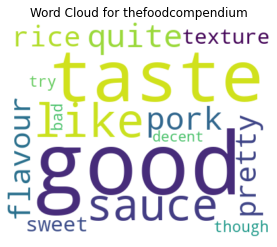

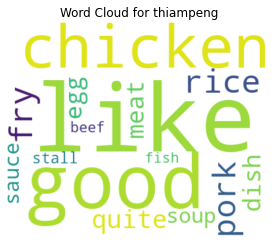

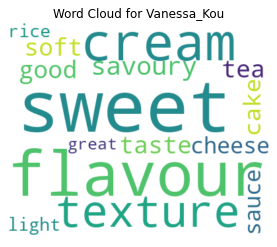

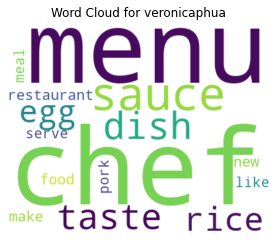

In [85]:
# word cloud for each reviewer
stopwords.extend(['u','w'])

for r in unique_reviewers:
    temp = final_reviews[final_reviews["reviewer"] == r]
    words = []
    for i in temp.cleaned_text:
        words.append(i)
    #Creating the text variable
    #text = " ".join("".join(review.translate(str.maketrans('','',string.punctuation)).split(" ")) for review in words)
    text = " ".join(" ".join(review.split(" ")) for review in words)
    # Creating word_cloud with text as argument in .generate() method
    word_cloud = WordCloud(width=400, height=330, max_words=15,collocations = False, stopwords= stopwords,background_color = 'white').generate(text)
    # Display the generated Word Cloud
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis("off")
    title = f"Word Cloud for {r}"
    plt.title(title)
    plt.show()

## Count and plot frequency of post by each reviewer per month

In [14]:
final_reviews['cleaned_date'] = final_reviews.apply(lambda x: 'Mar 2023' if 'ago' in x['date'] else str(x['date'].split("at")[0]+" 2023") if 'at' in x['date'] else str(x['date'].split(", ")[0]+" "+x['date'].split(", ")[-1]), axis = 1)
final_reviews['mmyyyy'] = final_reviews.apply(lambda x: x['cleaned_date'].strip()[:3]+ x['cleaned_date'].strip()[-4:], axis = 1)
final_reviews['DATE'] = pd.to_datetime(final_reviews['mmyyyy'],format='%b%Y')
final_reviews.head()

,name,address,review,date,link,reviewer,keep,cleaned_date,mmyyyy,DATE
12,Kazoku Japanese Cuisine,"1 Goldhill Plaza, Singapore ...",\n1-for-1 Don\nKazoku Chirashi Don (S$29.90++)...,4d ago,https://www.burpple.com/kazoku-japanese-cuisin...,alamakgirl,1,Mar 2023,Mar2023,2023-03-01
31,Tigerlily Patisserie,"350 Joo Chiat Road, Singapore ...","\nBrunch\nBeehive (S$15+)\nLemon, thyme and ly...",Feb 26 at 12:44pm,https://www.burpple.com/tigerlily-patisserie?b...,alamakgirl,1,Feb 26 2023,Feb2023,2023-02-01
32,Putien (Northpoint City) ...,"930 Yishun Avenue 2, Singapore ...",\nBirthday Treat \n20% discount \nValid during...,Feb 24 at 10:47pm,https://www.burpple.com/putien-8?bp_ref=%2Ff%2...,alamakgirl,1,Feb 24 2023,Feb2023,2023-02-01
35,Our Tampines Hub Hawker Centre (...,"1 Tampines Walk, Singapore ...",\nSet C\nSet C (S$2.50)\n‘Cos it’s Friday \nGo...,Feb 24 at 8:33am,https://www.burpple.com/our-tampines-hub?bp_re...,alamakgirl,1,Feb 24 2023,Feb2023,2023-02-01
51,Hokkaido Ramen Santouka (Clarke ...,"6 Eu Tong Sen Street, Singapore ...",\nBirthday Treat\n50% off Tokusen Toroniku Ram...,Feb 19 at 12:27pm,https://www.burpple.com/hokkaido-ramen-santouk...,alamakgirl,1,Feb 19 2023,Feb2023,2023-02-01


In [15]:
cal_dict = dict((month, index) for index, month in enumerate(calendar.month_abbr) if month)
cleaned_dates = []
for idx, row in final_reviews.iterrows():
    dt = row['date'].strip()
    if 'ago' in dt:
        if 'm' in dt or 'h' in dt or 's' in dt:
            cleaned_dates.append(date(2023, 3, 15))
        elif 'week' in dt:
            cleaned_dates.append(date(2023, 3, 8))
        else:
            dt_new = int(dt.replace('d ago', ''))
            dt_new = 15- dt_new
            cleaned_dates.append(date(2023, 3, dt_new))
            
    elif 'at' in dt:
        mth_day = dt.split(' ')
        new_date = date(2023, cal_dict[mth_day[0]], int(mth_day[1]))
        if new_date > date(2023,3,15):
            cleaned_dates.append(date(2022,cal_dict[mth_day[0]], int(mth_day[1])))
        else:
            cleaned_dates.append(date(2023, cal_dict[mth_day[0]], int(mth_day[1])))
    
    else:
        mth_day = dt.split(',')[0].split(' ')
        cleaned_dates.append(date(int(dt.split(',')[-1]), cal_dict[mth_day[0]], int(mth_day[1])))

final_reviews['cleaned_dates_datetime'] = cleaned_dates

In [16]:
freq = pd.DataFrame(final_reviews[['reviewer','DATE']].groupby(['reviewer', 'DATE']).size().reset_index())
freq.rename({0:'frequency'}, axis = 1)

,reviewer,DATE,frequency
0,Eatravel,2020-01-01,27
1,Eatravel,2020-02-01,13
2,Eatravel,2020-03-01,14
3,Eatravel,2020-04-01,11
4,Eatravel,2020-05-01,9
...,...,...,...
296,veronicaphua,2022-03-01,1
297,veronicaphua,2022-04-01,7
298,veronicaphua,2022-05-01,5
299,veronicaphua,2022-06-01,4


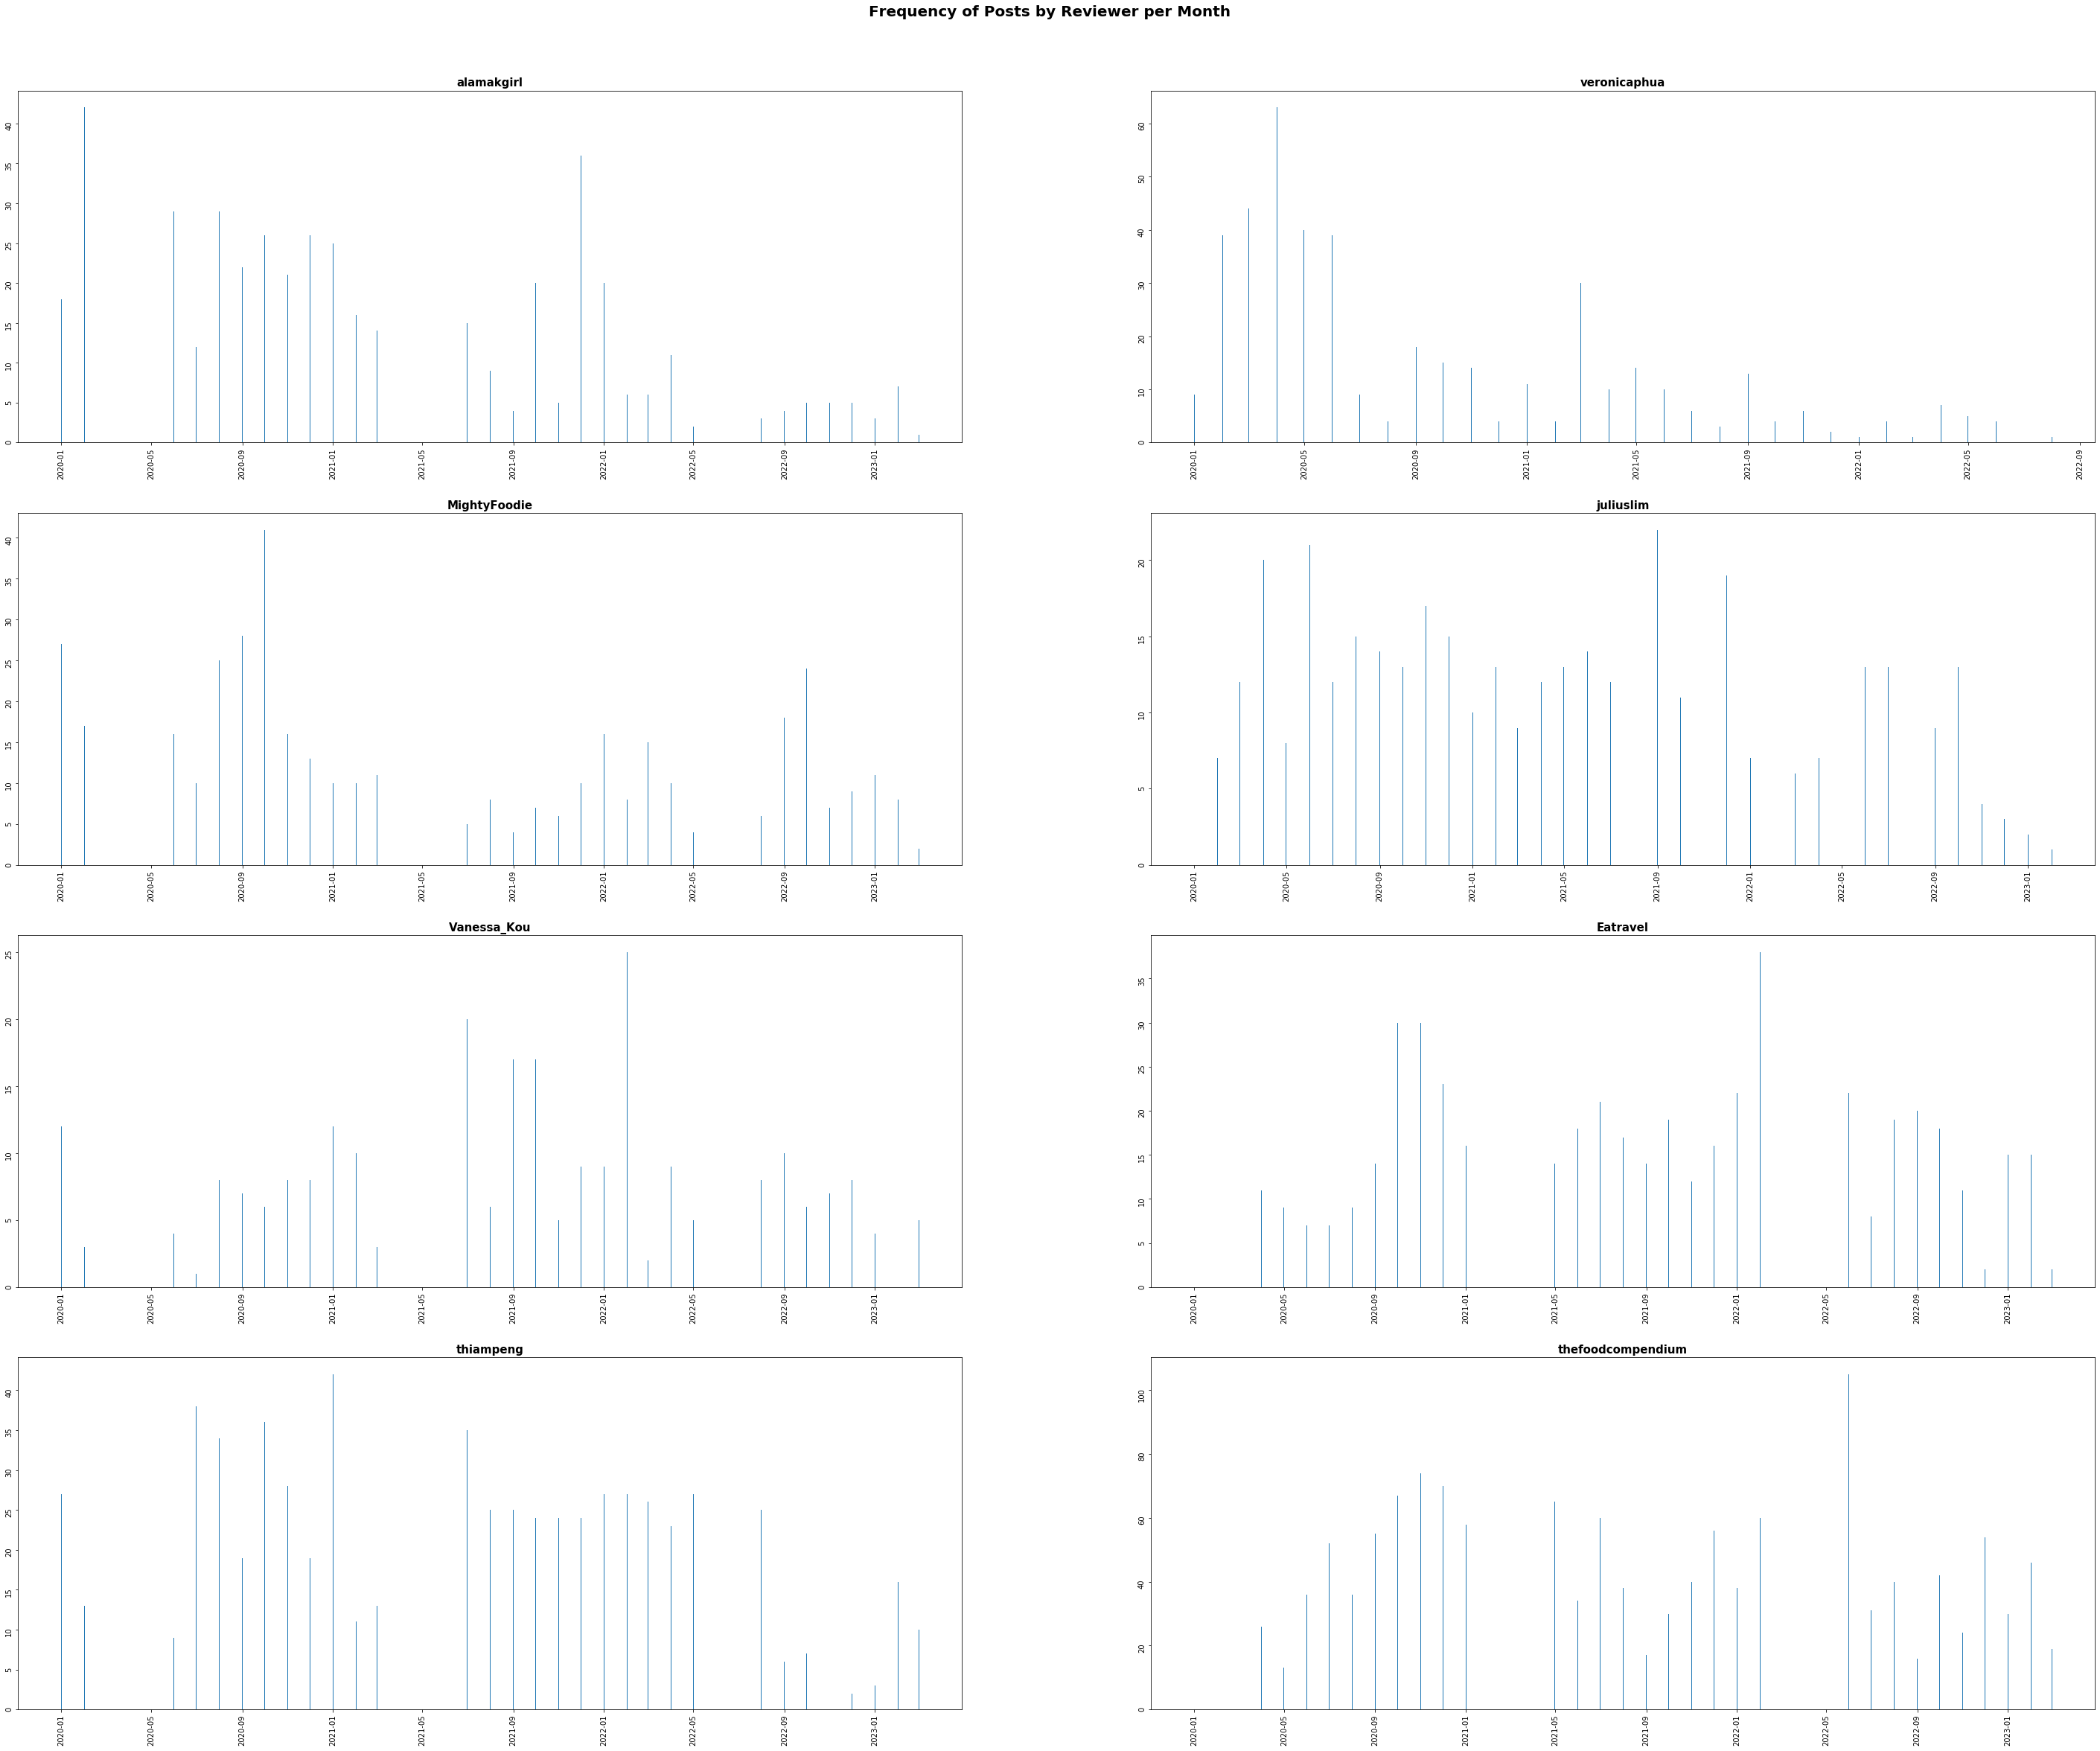

In [20]:
freq_alamakgirl = freq[freq['reviewer'] == 'alamakgirl']
#freq_alamakgirl.rename({0:'frequency'}, axis = 1)
freq_veronicaphua = freq[freq['reviewer'] == 'veronicaphua']
#freq_veronicaphua.rename({0:'frequency'}, axis = 1)
freq_MightyFoodie = freq[freq['reviewer'] == 'MightyFoodie']
#freq_MightyFoodie.rename({0:'frequency'}, axis = 1)
freq_juliuslim = freq[freq['reviewer'] == 'juliuslim']
#freq_juliuslim.rename({0:'frequency'}, axis = 1)
freq_Vanessa_Kou = freq[freq['reviewer'] == 'Vanessa_Kou']
#freq_Vanessa_Kou.rename({0:'frequency'}, axis = 1)
freq_Eatravel = freq[freq['reviewer'] == 'Eatravel']
#freq_Eatravel.rename({0:'frequency'}, axis = 1)
freq_thiampeng = freq[freq['reviewer'] == 'thiampeng']
#freq_thiampeng.rename({0:'frequency'}, axis = 1)
freq_thefoodcompendium = freq[freq['reviewer'] == 'thefoodcompendium']
#freq_thefoodcompendium.rename({0:'frequency'}, axis = 1)


fig, axs = plt.subplots(4,2, figsize=(50, 40))
axs[0][0].bar(freq_alamakgirl['DATE'], freq_alamakgirl[0])
axs[0][1].bar(freq_veronicaphua['DATE'], freq_veronicaphua[0])
axs[1][0].bar(freq_MightyFoodie['DATE'], freq_MightyFoodie[0])
axs[1][1].bar(freq_juliuslim['DATE'], freq_juliuslim[0])
axs[2][0].bar(freq_Vanessa_Kou['DATE'], freq_Vanessa_Kou[0])
axs[2][1].bar(freq_Eatravel['DATE'], freq_Eatravel[0])
axs[3][0].bar(freq_thiampeng['DATE'], freq_thiampeng[0])
axs[3][1].bar(freq_thefoodcompendium['DATE'], freq_thefoodcompendium[0])

fig.suptitle('Frequency of Posts by Reviewer per Month', fontsize=20, fontweight='extra bold', y=0.92, x=0.51)
axs[0][0].set_title('alamakgirl', fontsize=15, fontweight='bold')
axs[0][0].tick_params(labelrotation = 90)

axs[0][1].set_title('veronicaphua', fontsize=15, fontweight='bold')
axs[0][1].tick_params(labelrotation = 90)

axs[1][0].set_title('MightyFoodie', fontsize=15, fontweight='bold')
axs[1][0].tick_params(labelrotation = 90)

axs[1][1].set_title('juliuslim', fontsize=15, fontweight='bold')
axs[1][1].tick_params(labelrotation = 90)

axs[2][0].set_title('Vanessa_Kou', fontsize=15, fontweight='bold')
axs[2][0].tick_params(labelrotation = 90)

axs[2][1].set_title('Eatravel', fontsize=15, fontweight='bold')
axs[2][1].tick_params(labelrotation = 90)

axs[3][0].set_title('thiampeng', fontsize=15, fontweight='bold')
axs[3][0].tick_params(labelrotation = 90)

axs[3][1].set_title('thefoodcompendium', fontsize=15, fontweight='bold')
axs[3][1].tick_params(labelrotation = 90)

In [22]:
freq_by_month = final_reviews.groupby(['DATE']).size().reset_index()
freq_by_month.rename({0:'freq'}, axis = 1)

,DATE,freq
0,2020-01-01,195
1,2020-02-01,151
2,2020-03-01,213
3,2020-04-01,171
4,2020-05-01,121
5,2020-06-01,161
6,2020-07-01,141
7,2020-08-01,160
8,2020-09-01,177
9,2020-10-01,234


Text(0.5, 1.0, 'Frequency of posts by Month')

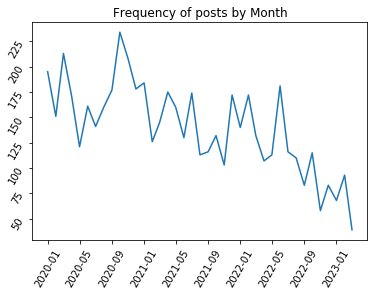

In [315]:
#freq_by_month.plot(x="DATE", y=[0], kind="bar")
plt.plot(freq_by_month['DATE'], freq_by_month[0])
plt.tick_params(labelrotation = 60)
title = "Frequency of posts by Month"
plt.title(title)


In [23]:
df_by_date = final_reviews.groupby('cleaned_dates_datetime')['link'].count().reset_index().iloc[:-8,:]
df_by_date

,cleaned_dates_datetime,link
0,2020-01-01,13
1,2020-01-02,16
2,2020-01-03,13
3,2020-01-04,6
4,2020-01-05,7
...,...,...
1040,2023-02-22,6
1041,2023-02-24,7
1042,2023-02-25,2
1043,2023-02-26,16


Text(0, 0.5, 'Num Reviews Per Month')

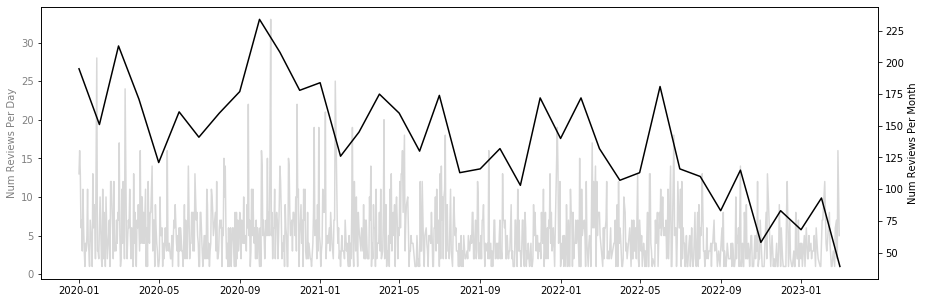

In [24]:
fig, ax1 = plt.subplots(figsize=(15,5))
fig.patch.set_facecolor('white')
ax1.set_facecolor('white')

ax1.plot(df_by_date['cleaned_dates_datetime'],df_by_date['link'],  color = 'grey', alpha = 0.3)
ax1.set_ylabel('Num Reviews Per Day', color = 'grey')
ax1.tick_params(axis = 'y', labelcolor = 'grey')
ax1.grid(False)
ax2 = ax1.twinx()
ax2.plot(freq_by_month['DATE'],freq_by_month[0], color = 'black')
ax2.set_ylabel('Num Reviews Per Month')

## Location of Restaurants Reviewed

In [217]:
locations = final_reviews['address'].unique()
print("No. of locations:", len(locations))

No. of locations: 574


In [316]:
#clean to see area
final_reviews['region'] = final_reviews['address'].apply(lambda x: str(x).replace(', Singapore', ''))
final_reviews['region'] = final_reviews['region'].apply(lambda x: "".join(filter(lambda x: not x.isdigit(),x)))

In [305]:
final_reviews['region'].head(2)

12                   Goldhill Plaza            
31                   Joo Chiat Road            
Name: region, dtype: object

In [282]:
res = final_reviews[['reviewer','region']].groupby('reviewer').nunique().reset_index()
res

,reviewer,region
0,Eatravel,64
1,MightyFoodie,93
2,Vanessa_Kou,57
3,alamakgirl,127
4,juliuslim,147
5,thefoodcompendium,178
6,thiampeng,119
7,veronicaphua,80


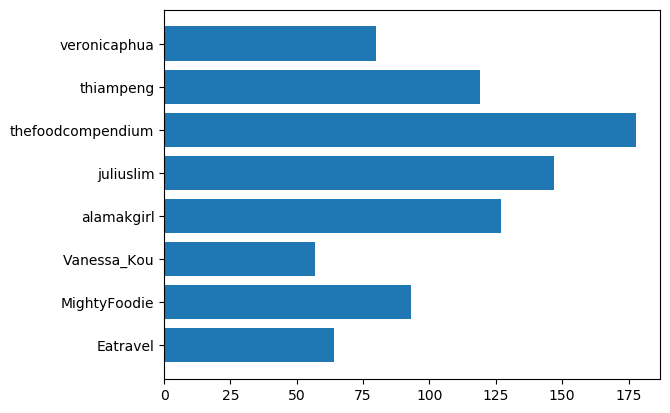

In [381]:
# num of region for each reviewer 
plt.barh(res.reviewer, res.region)
plt.show()

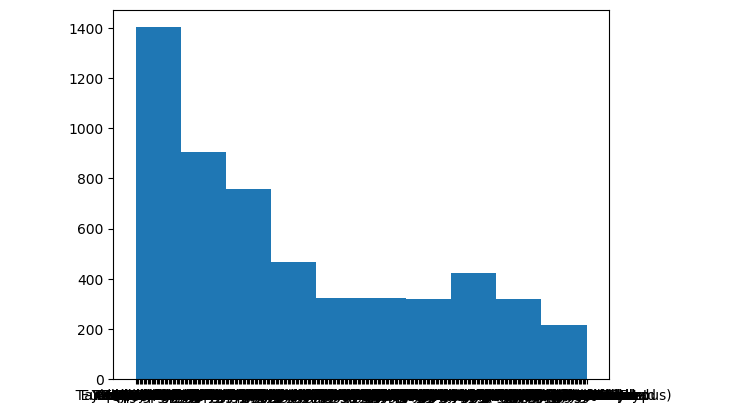

In [376]:
plt.hist(final_reviews.region)
plt.show()